In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/git_libraries/Yeominrak


In [2]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch
from collections import defaultdict, Counter
import copy
import numpy as np

from yeominrak_processing import AlignedScore, pack_collate, ShiftedAlignedScore
from model import Seq2seq, Converter, AttentionSeq2seq, QkvAttnSeq2seq
import random as random
from loss import nll_loss
from trainer import Trainer
from decode import MidiDecoder
from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence, pack_padded_sequence
import torch
from torch.utils.data import Dataset, DataLoader


In [3]:
train_dataset = ShiftedAlignedScore(is_valid = False, use_pitch_modification=False)
val_dataset = ShiftedAlignedScore(is_valid = True, slice_measure_num=5)

print(len(train_dataset), len(val_dataset))

139 63


In [19]:
train_loader = DataLoader(train_dataset, batch_size=64 , shuffle=True, collate_fn=pack_collate)
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=pack_collate, drop_last=True)

device = 'cuda'
# model = Seq2seq(train_dataset.tokenizer).to(device)
# model = AttentionSeq2seq(train_dataset.tokenizer).to(device)
model = QkvAttnSeq2seq(train_dataset.tokenizer, hidden_size=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nll_loss
trainer = Trainer(model, optimizer, loss_fn, train_loader, valid_loader, device)


In [5]:
batch = next(iter(train_loader))
x, y, shifted_y = batch
print(model(x.cuda(), y.cuda()))

AttributeError: 'tuple' object has no attribute 'data'

In [20]:
model.to(device)
trainer.train_by_num_epoch(200)

  0%|          | 0/200 [00:00<?, ?it/s]

Best Model Saved! Accuracy: 0.21155830753353974
Best Model Saved! Accuracy: 0.21929824561403508
Best Model Saved! Accuracy: 0.22084623323013416
Best Model Saved! Accuracy: 0.24097007223942207
Best Model Saved! Accuracy: 0.2807017543859649
Best Model Saved! Accuracy: 0.29669762641898867
Best Model Saved! Accuracy: 0.325593395252838
Best Model Saved! Accuracy: 0.34674922600619196
Best Model Saved! Accuracy: 0.3493292053663571
Best Model Saved! Accuracy: 0.3715170278637771
Best Model Saved! Accuracy: 0.38338493292053666
Best Model Saved! Accuracy: 0.39834881320949433
Best Model Saved! Accuracy: 0.40763673890608876
Best Model Saved! Accuracy: 0.4329205366357069
Best Model Saved! Accuracy: 0.45252837977296184
Best Model Saved! Accuracy: 0.4582043343653251
Best Model Saved! Accuracy: 0.46078431372549017
Best Model Saved! Accuracy: 0.4680082559339525
Best Model Saved! Accuracy: 0.47316821465428277
Best Model Saved! Accuracy: 0.4855521155830753
Best Model Saved! Accuracy: 0.48968008255933954
B

[tensor([[[1.5598e-03, 6.2446e-04, 2.5003e-08,  ..., 1.9791e-02,
           1.9791e-02, 1.9791e-02],
          [1.4206e-01, 4.5000e-03, 6.1511e-03,  ..., 4.1156e-02,
           4.1156e-02, 4.1156e-02],
          [5.3040e-02, 1.3793e-08, 7.1241e-01,  ..., 3.7375e-02,
           3.7375e-02, 3.7375e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[2.9590e-02, 5.8862e-02, 3.4701e-08,  ..., 1.2208e-02,
           1.2208e-02, 1.2208e-02],
          [7.5000e-01, 2.6915e-03, 3.6598e-04,  ..., 2.9290e-02,
           2.9290e-02, 2.9290e-02],
          [1.0395e-01, 4.1539e-01, 2.4453e-06,  ..., 3.2915e-02,
           3.2915e-02, 3.2915e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.000

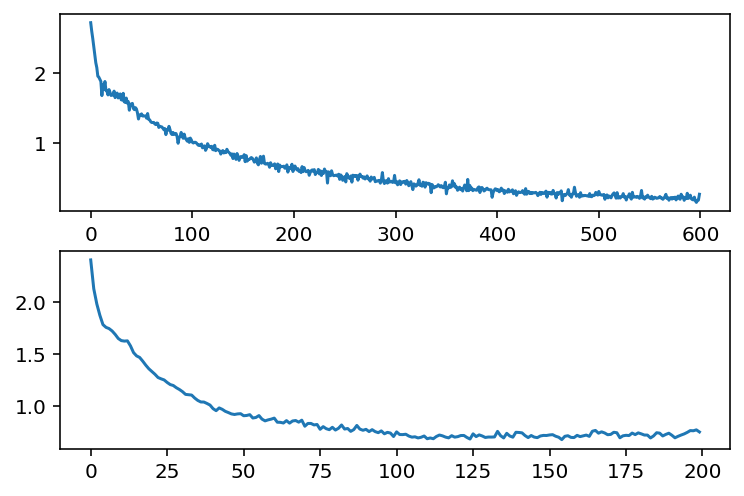

In [21]:
from matplotlib import pyplot as plt

plt.subplot(2,1,1)
plt.plot(trainer.training_loss)
plt.subplot(2,1,2)
plt.plot(trainer.validation_loss)

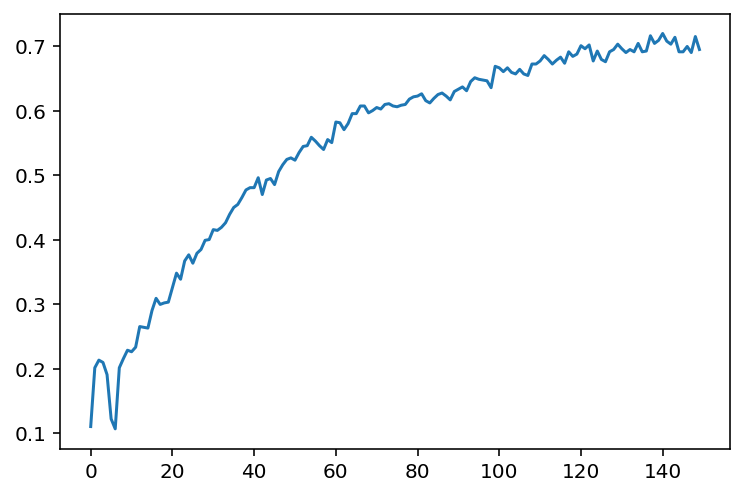

In [12]:
plt.plot(trainer.validation_acc)

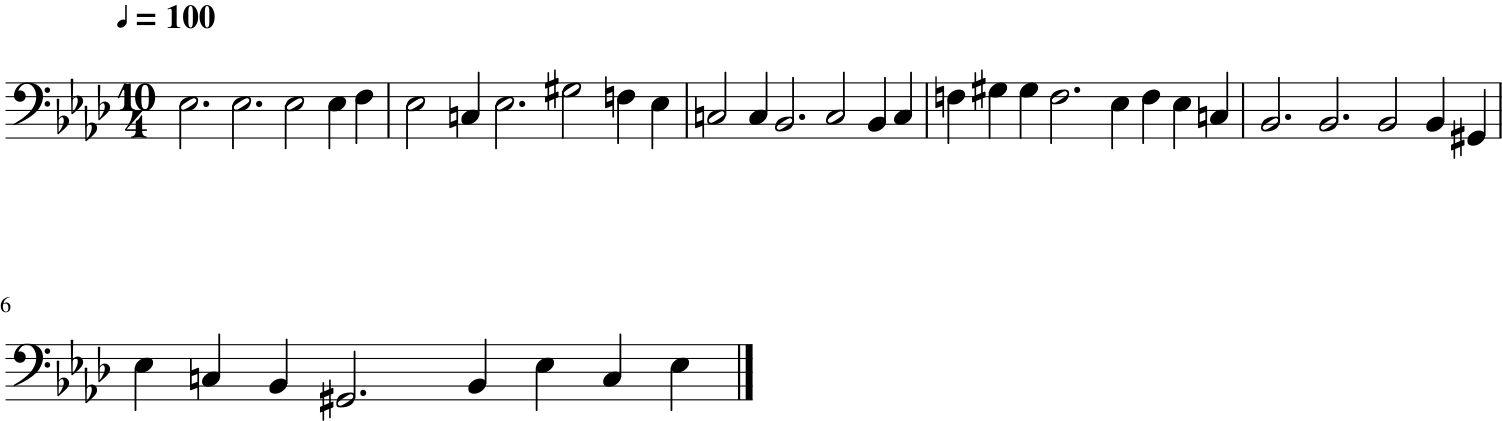

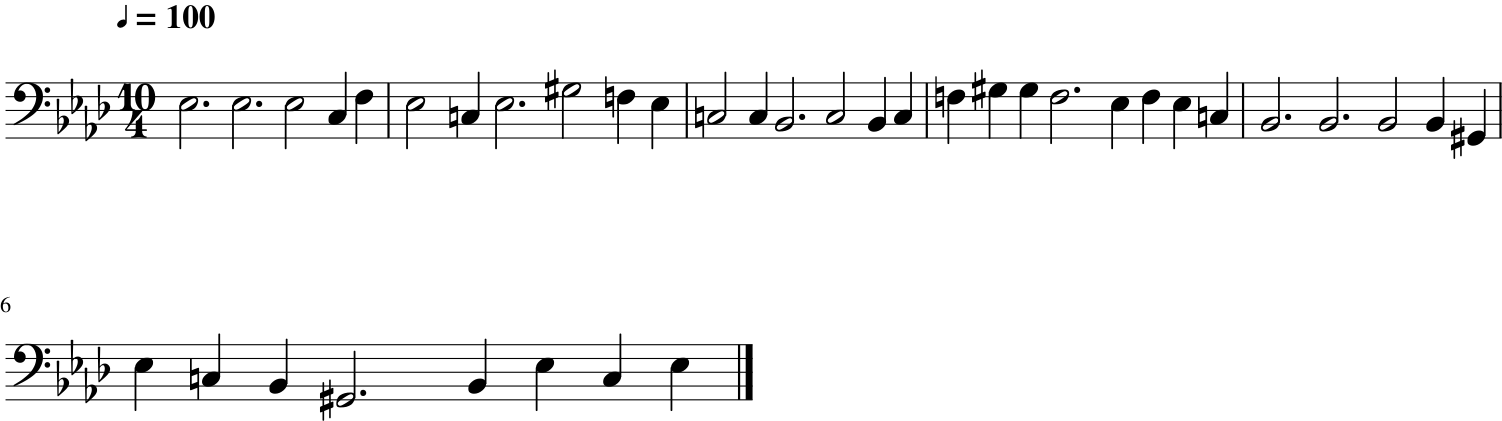

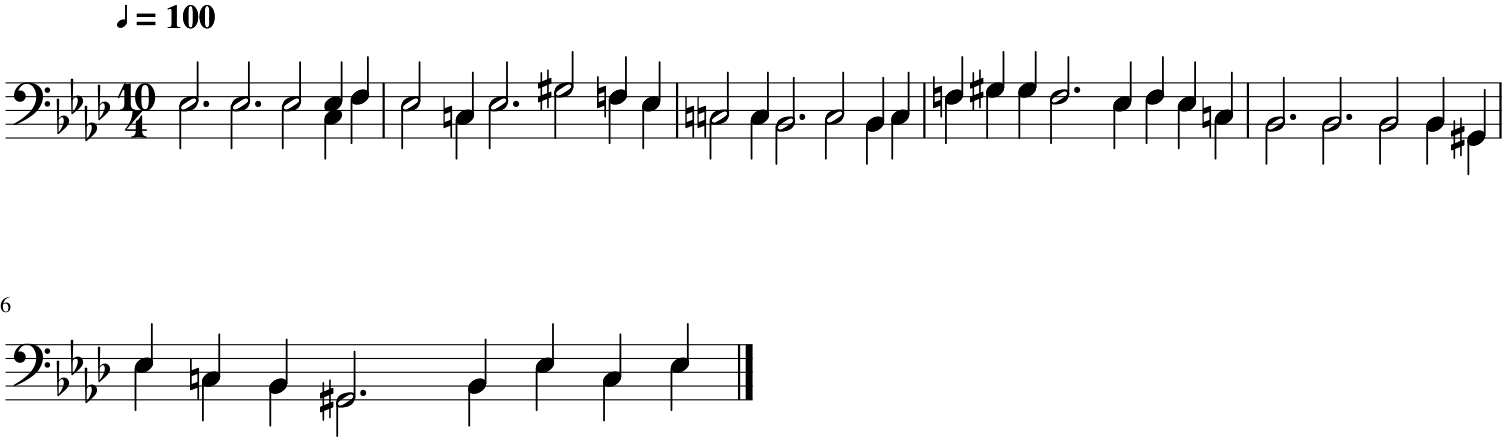

In [27]:
converter = Converter(train_dataset.tokenizer.vocab)
decoder = MidiDecoder(model, valid_loader)

rand_idx = random.random()
src,_, shifted_tgt = train_dataset[100]

src = converter(src[1:-1])
shifted_tgt = converter(shifted_tgt[:-1])

src_midi = decoder(src)
output_midi = decoder(shifted_tgt)

src_midi.show()
output_midi.show()
# (src_midi + output_midi).show('musicxml.png')


In [77]:
src_midi.write('musicxml.png', 'test.png')

PosixPath('/home/teo/userdata/git_libraries/Yeominrak/test-1.png')

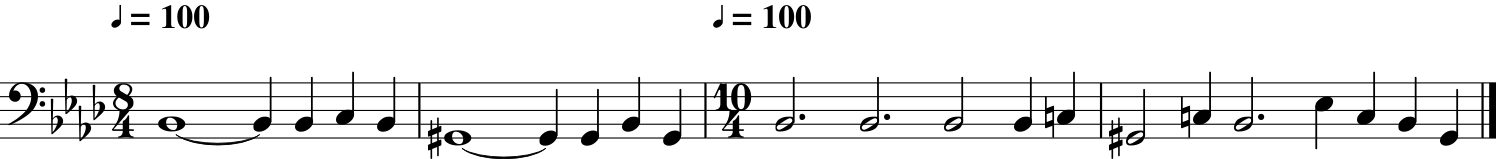

In [78]:
mergedStream = stream.Stream()
for element in src_midi:
    mergedStream.append(element)
for element in output_midi:
    mergedStream.append(element)
mergedStream.show()

## Inference

In [22]:
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=pack_collate)
model.to('cpu')
val_part_idx_info = defaultdict(list)
for i, val in enumerate(val_dataset):
    val_part_idx_info[int(val[0][0][0])].append(i)
val_part_idx_info

defaultdict(list,
            {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
             1: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
             2: [28, 29, 30, 31, 32, 33, 34],
             3: [35, 36, 37, 38, 39, 40, 41],
             5: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55],
             6: [56, 57, 58, 59, 60, 61, 62]})

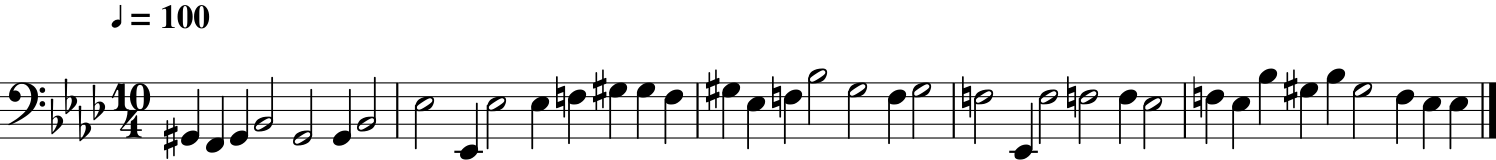

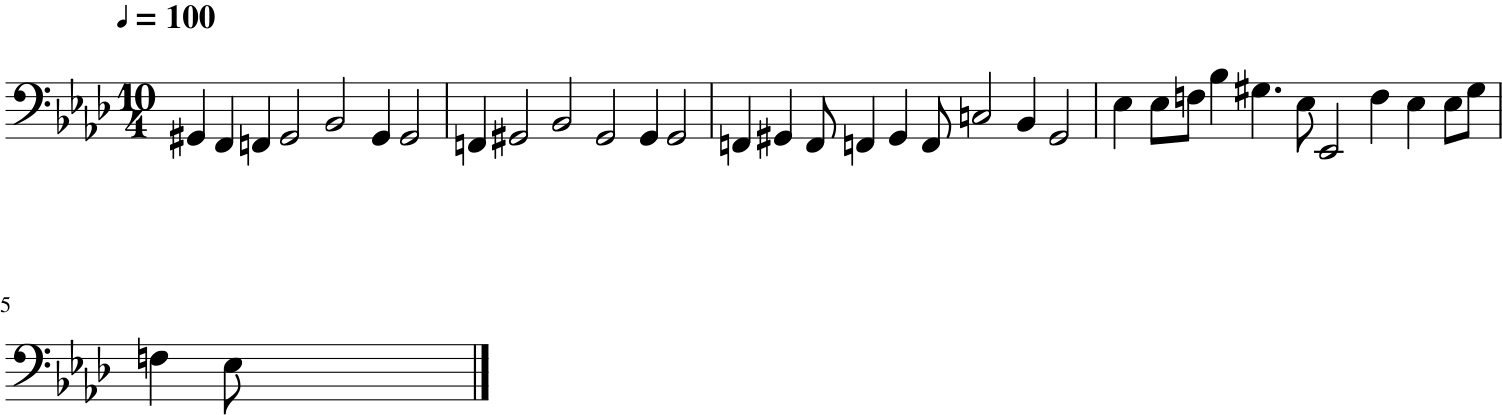

In [23]:
model.cpu()
valid_dataset_idx = 56
output_part_idx = 7

sample = valid_loader.dataset[valid_dataset_idx][0]
# src, output, attention_map = model.shifted_inference(sample, output_part_idx)
src, output, attention_map = model.shifted_inference(sample, output_part_idx)

decoder = MidiDecoder(model, valid_loader)
src_midi = decoder(src)
output_midi = decoder(output)
src_midi.show()
output_midi.show()


## Attention map

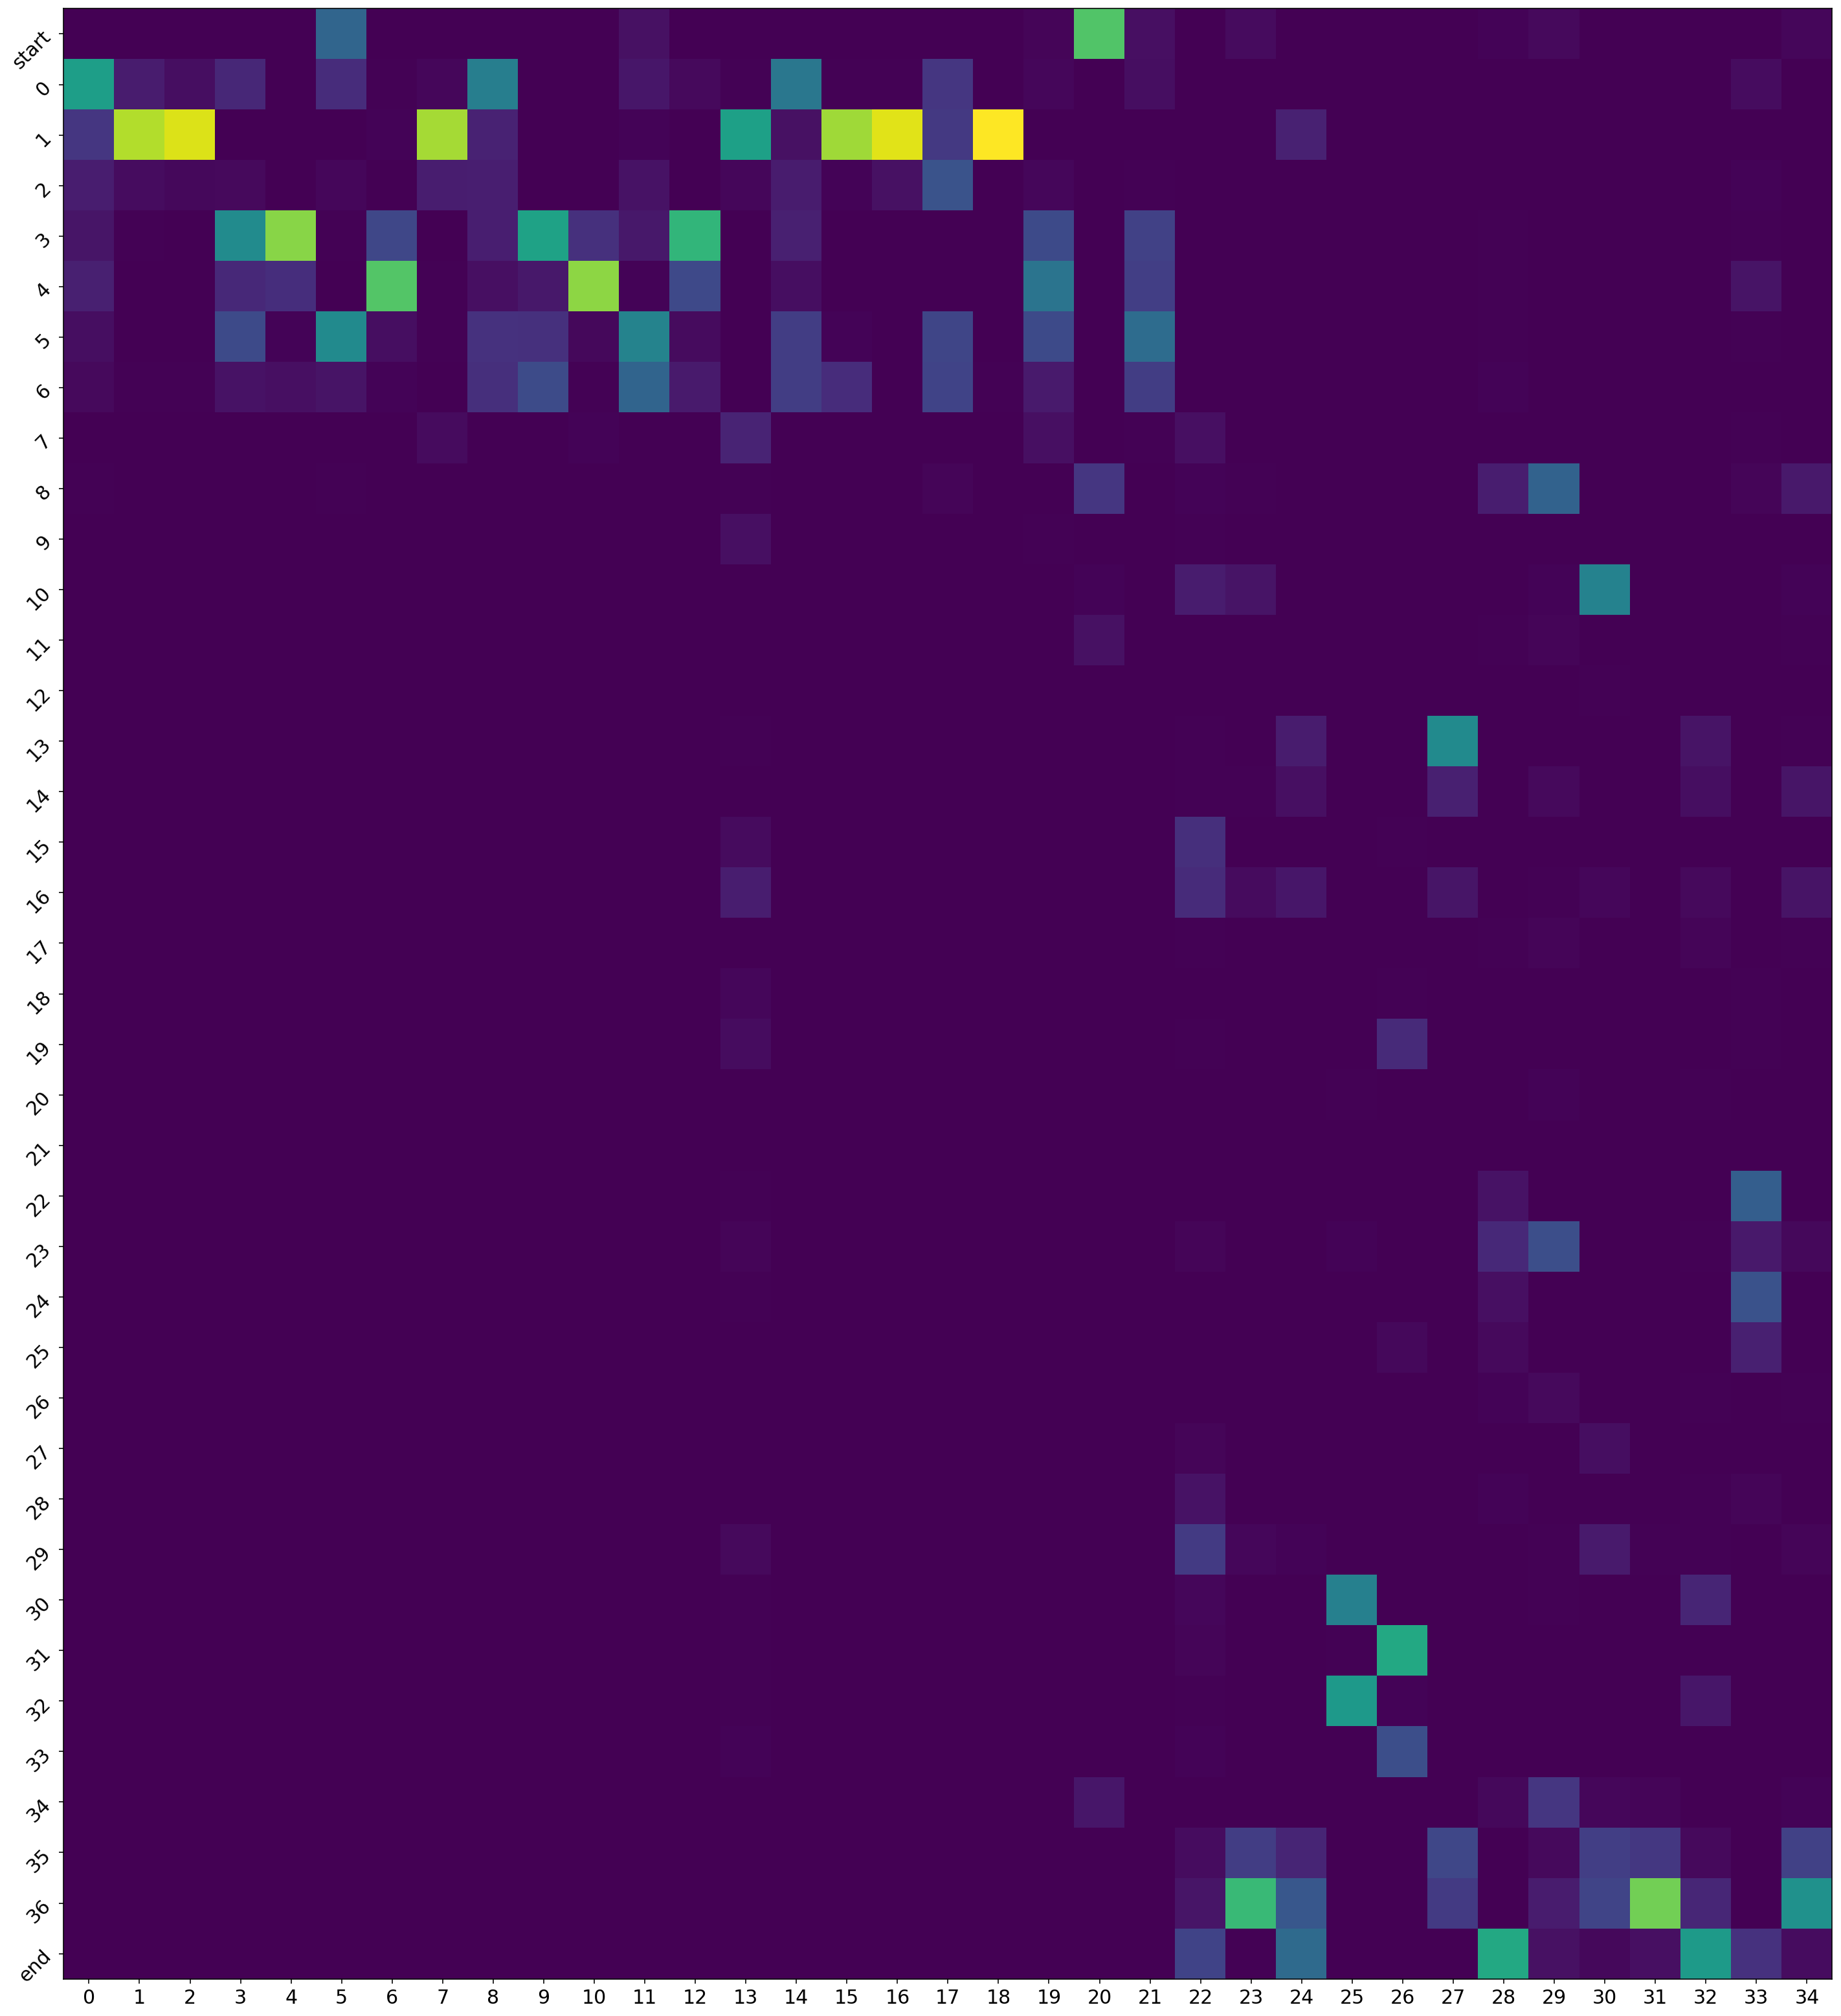

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(len(src)*0.8, len(output)*0.8))
x_axis_label = ['start']+[i for i, x in enumerate(src)]+['end']
y_axis_label = [i for i, x in enumerate(output)]

plt.imshow(attention_map.detach())
plt.yticks(range(len(x_axis_label)), x_axis_label, fontsize=15,rotation = 45)
plt.xticks(range(len(y_axis_label)), y_axis_label, fontsize=15)
plt.show()

# Other works

In [ ]:
import matplotlib.pyplot as plt
plt.plot(part5.make_pitch_contour())

In [ ]:
# part, i = score_set.score.parts[5], 5
# part5 = Part(part, i)
# part5.measure_duration
# print(part5.measures)

# while True:
  entire_beat = part5.measure_duration
  for measure in part5.measures:
    part = score_set.score.parts[5]
# part5 = Part(part, i) 
    current_beat = sum(note.duration for note in measure)
    # print(current_beat, entire_beat)
    if current_beat < entire_beat:
      # print(current_beat, entire_beat)
      # print(measure)
      # print(measure[-1].offset, measure[-1].duration)
      new_note = m21_note.Note(pitch=30, quarterLength=entire_beat - current_beat)
      part.insert(measure[-1].offset+measure[-1].duration, new_note)
      # measure.append(Gnote(m21_note.Note(pitch=30, quarterLength=entire_beat - current_beat, offset=measure[-1].offset+measure[-1].duration), 5))
      print('added!')
      break
  
  # sum_list = [sum(note.duration for note in measure) for measure in part5.measures]
  # if sum(sum_list) == len(part5.measures) * entire_beat:
  #   print("done?")
  #   break
  
# for i, measure in enumerate(part5.measures):
#   current_beat = sum(note.duration for note in measure)
#   entire_beat = part5.measure_duration
#   if current_beat < entire_beat:
#     print(measure)

In [ ]:
whole_score = converter.parse(file_list[0])

by_measure_parse_dic = defaultdict()
for part_idx in range(len(whole_score.parts)):
  part_dic = defaultdict(list)
  for note in whole_score.parts[part_idx].flat.notes:
    if not note.duration.isGrace:
      part_dic[note.measureNumber].append(note)
  by_measure_parse_dic[part_idx] = part_dic


In [ ]:
part.measure

In [ ]:
print(score_set.parts[5].make_pitch_contour())

In [ ]:
contours = [part.make_pitch_contour() for part in score_set.parts]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

measure_sample = 120
measure_by_contour = [contours[-1][i * measure_sample : (i + 1) * measure_sample] for i in range(160)]

self_similarity_matrix = np.zeros((160, 160))

for i, measure1 in enumerate(measure_by_contour):
    for j, measure2 in enumerate(measure_by_contour):
        similarity = np.sum(measure1 == measure2) / measure_sample  # Calculate similarity
        self_similarity_matrix[i, j] = similarity

plt.figure(figsize=(12, 12))
plt.imshow(self_similarity_matrix, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Self-Similarity Matrix')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

measure_start = 80
measure_end = 100

sampling_rate = 12

start_idx = measure_start * 10 * sampling_rate
end_idx = measure_end * 10 * sampling_rate

plt.figure(figsize = (50, 10))
for contour in contours:
  plt.plot(contour[start_idx:end_idx])


In [ ]:
len(score_set.parts[0].measures)

In [ ]:
12/5

In [ ]:
score_set.parts[-1].measure_duration

In [ ]:
min([note.duration for note in score_set.parts[-3].tie_cleaned_notes])

In [ ]:
for i, part in enumerate(train_dataset.parts):
  for j, measure in enumerate(part.measures):
    for note in measure:
      if note.pitch == 49:
        print(i, j, note)
